# Code to Solve the Compressed-Sensing Magnetic Resonance Imaging (CS-MRI) Reconstruction Problem

## Problem formulation

$\boldsymbol{y} = \boldsymbol{M} \odot (\boldsymbol{F} \boldsymbol{X} \boldsymbol{F} + \boldsymbol{\varepsilon}) , \hspace{2ex} \boldsymbol{\varepsilon} \sim \mathcal{N} (0, \sigma^2 \boldsymbol{I}), \hspace{2ex} \sigma \geq 0.$

- $\boldsymbol{X} \in \mathbb{R}^{n \times n}$: unknown image to recover 
- $\boldsymbol{F} \in \mathbb{C}^{n \times n}$: DFT matrix (https://en.wikipedia.org/wiki/DFT_matrix) 
- $\boldsymbol{M} \in \{0 ,1\}^{n \times n}$: 0-1 mask that denotes which Fourier coefficients are observed 
- $\boldsymbol{\varepsilon} \in \mathbb{R}^{m}$: noise
- $ \sigma \in \mathbb{R}^+$: noise level 
- $ \boldsymbol{y} \in \mathbb{C}^{m}$: observed measurements (Fourier coefficients) 
- $ \odot : \mathbb{C}^{n_1 \times n_2} \times \mathbb{C}^{n_1 \times n_2} \mapsto \mathbb{C}^{n_1 \times n_2}$: denotes the Kronecker product (https://en.wikipedia.org/wiki/Kronecker_product)


## Loss function, gradients

### Loss function:

$\ell ({\boldsymbol{X}}) = \frac{1}{2m} \| \boldsymbol{M} \odot (\boldsymbol{y} - \boldsymbol{F} \boldsymbol{X} \boldsymbol{F}) \|_2^2$

### Loss function as a finite sum:

$\ell (\boldsymbol{X}) := \frac{1}{m} \sum_{\{ i, j | y_{i, j} \not= 0 \}} \ell_{i,j}(\boldsymbol{X}) = \frac{1}{m}\sum_{\{ i, j | y_{i, j} \not= 0 \}} \frac{1}{2}(y_i - \boldsymbol{f}_i^\top \boldsymbol{X} \boldsymbol{f}_j)^2$

- $\boldsymbol{f}_i \in \mathbb{C}^m$: the $i^{\text{th}}$ column of the DFT matrix $\boldsymbol{F}$.


### Full gradient:

$\nabla \ell ({\boldsymbol{X}}) = \frac{1}{m}\boldsymbol{F}^\dagger \boldsymbol{M} \odot(\boldsymbol{y} - \boldsymbol{F} \boldsymbol{X} \boldsymbol{F} ) \boldsymbol{F}^\dagger$

### Stochastic gradient:

$\nabla \ell_{i,j}({\boldsymbol{X}}) = (y_i - \boldsymbol{f}_j^\dagger \boldsymbol{X}^\dagger \boldsymbol{f}_i^\ast) \boldsymbol{f}_j^\dagger\boldsymbol{f}^\ast $

- $\dagger : \mathbb{C}^{n_1 \times n_2} \mapsto \mathbb{C}^{n_2 \times n_1} $: Hermitian transpose
- $\ast : \mathbb{C}^{n_1 \times n_2} \mapsto \mathbb{C}^{n_1 \times n_2} $: Complex conjugate

In [1]:
from ipynb.fs.full.csmri_gradients import full_grad, stoch_grad, get_batch

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from os.path import dirname, abspath
import os
import matplotlib.pyplot as plt
from PIL import Image
import time

from skimage import data, img_as_float
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage.metrics import peak_signal_noise_ratio
from skimage.util import random_noise

In [4]:
np.random.seed(5)

## Set paths
data_path="../data/Set12/"
save_path="./figures/"
image_list = sorted(os.listdir(data_path))

## Read test image
# normalize image pixels in range [0,1]
# orig = np.array(Image.open(data_path + image_list[8])) / 225.0
ORIG = Image.open(data_path + image_list[12]).resize((256,256))
ORIG = np.array(ORIG) / 255.0
mintmp = np.min(ORIG)
maxtmp = np.max(ORIG)
ORIG = (ORIG - mintmp) / (maxtmp - mintmp)

(-0.5, 255.5, 255.5, -0.5)

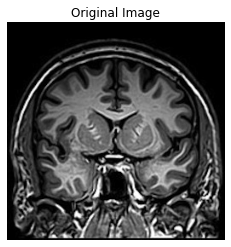

In [5]:
## Display original image
orig_fig = plt.figure()
ax = orig_fig.add_subplot(1, 1, 1)
orig_plot = plt.imshow(ORIG, cmap='gray', vmin=0, vmax=1)
ax.set_title('Original Image')
ax.axis('off')

In [6]:
## Set signal model parameters
prob = .5 							# percentage of Fourier coefficients measured
H, W = ORIG.shape[:2] 				# height and width of orig image
N = H*W 							# image dimension
sigma = 1							# noise level of measurements

## Make measurements
mask = np.random.choice([0, 1], size=(H,W), p=[1 - prob, prob])	# generate random mask

index = np.nonzero(mask)
index = np.transpose(index)

noises = np.random.normal(0, sigma, (H,W))						# generate random noise
forig = np.fft.fft2(ORIG)										# fft2 of image
y0 = np.multiply(forig, mask)									# noiseless measurements
y = y0 + noises 												# noisy measurements

## Initialize variables
x_init = np.abs(np.fft.ifft2(y))
mintmp = np.min(x_init)
maxtmp = np.max(x_init)
x_init = (x_init - mintmp) / (maxtmp - mintmp)
x = np.copy(x_init)

In [ ]:
x_diff = ORIG - x_init

## Display inverse 2D-DFT of observed Fourier coefficients

fig, axs = plt.subplots(1, 1, tight_layout=True)

# We can set the number of bins with the `bins` kwarg
axs = plt.imshow(x_diff, cmap='gray', vmin=0, vmax=1)
plt.show()

x_diff = np.matrix.flatten(x_diff)

_ = plt.hist(np.matrix.flatten(x_diff), bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.show()

print(np.mean(x_diff), np.std(x_diff))

(-0.5, 255.5, 255.5, -0.5)

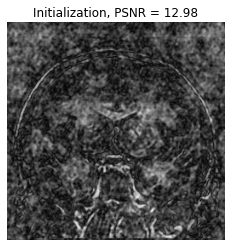

In [7]:
## Display inverse 2D-DFT of observed Fourier coefficients
init_fig = plt.figure()
ax = init_fig.add_subplot(1, 1, 1)
init_plot = plt.imshow(x_init, cmap='gray', vmin=0, vmax=1)
ax.set_title(f'Initialization, PSNR = {peak_signal_noise_ratio(x_init, ORIG):0.2f}')
ax.axis('off')

In [8]:


# filter_array = np.linspace(0, 0.06, 1000)

# patch_kw = dict(patch_size=5,      # 5x5 patches
#                 patch_distance=6,  # 13x13 search area
#                 multichannel=True)

# psnr_list = []
# for i in range(1000):
#     test_denoise = denoise_nl_means(np.real(x_init), h=filter_array[i], fast_mode=True, **patch_kw)
#     psnr_list.append(peak_signal_noise_ratio(test_denoise, ORIG))

# svrg_fig = plt.figure()
# ax = svrg_fig.add_subplot(1, 1, 1)
# svrg_plot = plt.plot(filter_array, psnr_list)
# ax.set_title(f"Filter Size vs. PSNR recovery")
# ax.axis('on')
# plt.show()

$\begin{equation}
	\textbf{PnP-SVRG}(\boldsymbol{x}_0, \eta, T_1, T_2): \\
	\text{for } s = 1, 2, . . ., T_1 \text{ do} \\
	\hspace{2ex} \tilde{\boldsymbol{x}} = \boldsymbol{x}_{s-1} \\
	\hspace{2ex} \boldsymbol{w} = \underbrace{\nabla d(\tilde{\boldsymbol{x}})}_{\text{full gradient}} \\
	\hspace{2ex} \boldsymbol{x}_0 = \tilde{\boldsymbol{x}} \\
	\hspace{2ex} \text{for } t = 1, 2, . . ., T_2 \text{ do} \\
	\hspace{4ex} \text{pick } i_t \in \{ 1, ..., m \} \text{ randomly} \\
	\hspace{4ex} \boldsymbol{v}_t = \underbrace{\nabla d_{i_t} (\boldsymbol{x}_{t-1}) - \nabla d_{i_t} (\tilde{\boldsymbol{x}}) + \boldsymbol{w}}_{\text{stochastic variance-reduced gradient}} \\
	\hspace{4ex} \boldsymbol{x}_t = \text{denoise}_\sigma (\boldsymbol{x}_{t-1} - \eta \boldsymbol{v}_t) \\
	\hspace{2ex} \text{end} \\
	\hspace{2ex} \text{set } \boldsymbol{x}_s = \boldsymbol{x}_{T_2} \\
	\text{end} \\
    \textbf{Output } \boldsymbol{x}_{T_1}
\end{equation}$

In [ ]:
def PnP_SVRG_CSMRI(z, MASK, meas, eta, T1, T2, batch_size, FILTER, patch, orig):
    ## See pseudocode above

    ## Obtain info from inputs
    H, W = z.shape[:2] # image dimensions
    index = np.transpose(np.nonzero(MASK)) # nonzero indices of the mask

    ## Initialize time-keeping variables
    time_per_iter = []
    psnr_per_iter = []
    t0 = 0

    ## Main PnP SVRG routine
    for i in range(T1):
        # outer loop
        mu = full_grad(z, MASK, meas)   	# Gradient at reference point
        w = np.copy(z) 					# Initialize reference point
        start_iter = time.time()
        print(mu)

        for j in range(T2):
            ## inner loop
            ind = get_batch(batch_size, MASK) 	# Get batch index(indices) in terms of (row, col)

            ## calculate stochastic variance-reduced gradient
            v = stoch_grad(z, ind, meas) - stoch_grad(w, ind, meas) + mu 

            ## take gradient step
            z = np.real(z - eta*v)

            print("grad " + str(i) + " " + str(j) + " " + str(peak_signal_noise_ratio(orig, z)) + " " + str(np.linalg.norm(meas - MASK * np.fft.fft2(z)**2, 'fro')))            
            
            # Denoising
            ztilde = np.copy(z)
            z = denoise_nl_means(np.real(ztilde), h=FILTER, fast_mode=True, **patch)
            
            print("denoise " + str(i) + " " + str(j) + " " + str(peak_signal_noise_ratio(orig, z)))

        ## Calculate time and PSNR difference per outer loop
        stop_iter = time.time()
        time_per_iter.append(stop_iter - start_iter)
        psnr_per_iter.append(peak_signal_noise_ratio(ORIG, z))
    ## Output final iterate, time keeping
    return z, time_per_iter, psnr_per_iter

In [ ]:
## Run PnP-SVRG
T_outer = 300 				# Number of outer loop iterations
T_inner = 2 				# Number of inner loop iterations
eta_SVRG = .4 				# step size for SVRG
batch_size_SVRG= int(np.rint(np.count_nonzero(mask) / T_inner))
NLM_filter = 0.015
patch_kw = dict(patch_size=5,      # 5x5 patches
                patch_distance=6,  # 13x13 search area
                multichannel=True)

output_SVRG, time_per_iter_SVRG, psnr_per_iter_SVRG = PnP_SVRG_CSMRI(x_init, mask, y, eta_SVRG, \
                                                                     T_outer, T_inner, batch_size_SVRG, \
                                                                     NLM_filter, patch_kw, ORIG)


In [ ]:
## Display original image
orig_fig = plt.figure()
ax = orig_fig.add_subplot(1, 1, 1)
orig_plot = plt.imshow(ORIG, cmap='gray', vmin=0, vmax=1)
ax.set_title('Original Image')
ax.axis('off')

# get rescaled version for calculating PSNR
mintmp = np.min(output_SVRG)
maxtmp = np.max(output_SVRG)
output_SVRG = (output_SVRG - mintmp) / (maxtmp - mintmp)
            
## Display output of PnP-SVRG algorithm
psnr_output_SVRG = peak_signal_noise_ratio(ORIG, output_SVRG)
svrg_fig = plt.figure()
ax = svrg_fig.add_subplot(1, 1, 1)
svrg_plot = plt.imshow(np.real(output_SVRG), cmap='gray', vmin=0, vmax=1)
ax.set_title(f"PnP-SVRG (Ours), PSNR = {psnr_output_SVRG:0.2f}")
ax.axis('off')

# Figure to display iteration count/ clock time vs PSNR for all algorithms
psnr_fig, psnr_ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 6))

psnr_ax[0].plot(np.cumsum(time_per_iter_SVRG), psnr_per_iter_SVRG)

psnr_ax[1].plot(range(np.cumsum(time_per_iter_SVRG).size), psnr_per_iter_SVRG)

psnr_ax[0].set(xlabel='time (s)', ylabel='PSNR (dB)')
psnr_ax[0].legend(({'PnP-SVRG'}), loc='lower right')
psnr_ax[0].grid()

psnr_ax[1].set(xlabel='iteration', ylabel='PSNR (dB)')
psnr_ax[1].legend({"PnP-SVRG"}, loc='lower right')
psnr_ax[1].grid()

psnr_fig.tight_layout()

plt.show()

In [ ]:
# ## Set signal model parameters
# num_trials = 20
# prob = np.linspace(0, 1, num_trials) 							# percentage of Fourier coefficients measured
# H, W = ORIG.shape[:2] 				# height and width of orig image
# N = H*W 							# image dimension
# sigma = 1							# noise level of measurements

# ## Run PnP-SVRG
# T_outer = 50 				# Number of outer loop iterations
# T_inner = 20 				# Number of inner loop iterations
# eta_SVRG = .095 				# step size for SVRG
# batch_size_SVRG=1400
# NLM_filter = .015
# patch_kw = dict(patch_size=5,      # 5x5 patches
#                 patch_distance=6,  # 13x13 search area
#                 multichannel=True)

# psnr_per_trial = []

# for i in range(num_trials):
#     ## Make measurements
#     mask = np.random.choice([0, 1], size=(H,W), p=[1 - prob[i], prob[i]])	# generate random mask
#     index = np.nonzero(mask)
#     index = np.transpose(index)

#     noises = np.random.normal(0, sigma, (H,W))						# generate random noise
#     forig = np.fft.fft2(ORIG)										# fft2 of image
#     y0 = np.multiply(forig, mask)									# noiseless measurements
#     y = y0 + noises 												# noisy measurements

#     ## Initialize variables
#     x_init = np.absolute(np.fft.ifft2(y))
#     mintmp = np.min(x_init)
#     maxtmp = np.max(x_init)
#     x_init = (x_init - mintmp) / (maxtmp - mintmp)
#     x = np.copy(x_init)
    
#     output_SVRG, time_per_iter_SVRG, psnr_per_iter_SVRG = PnP_SVRG_CSMRI(x_init, mask, y, eta_SVRG, \
#                                                                      T_outer, T_inner, batch_size_SVRG, \
#                                                                      NLM_filter, patch_kw, ORIG)
#     psnr_per_trial.append(psnr_per_iter_SVRG[-1])
    
# svrg_fig = plt.figure()
# ax = svrg_fig.add_subplot(1, 1, 1)
# svrg_plot = plt.plot(prob, psnr_per_trial)
# ax.set_title(f"Sampling Rate vs. PSNR recovery")
# ax.axis('on')
# plt.show()

In [ ]:
# svrg_fig = plt.figure()
# ax = svrg_fig.add_subplot(1, 1, 1)
# svrg_plot = plt.plot(prob, psnr_per_trial[20:40])
# ax.set_title(f"Sampling Rate vs. PSNR recovery")
# ax.axis('on')
# plt.show()

$\begin{equation}
    \textbf{PnP-GD}(\boldsymbol{x}_0, \eta, T): \\
    \text{for } t = 1, 2, . . ., T \text{ do} \\
	\hspace{2ex} \boldsymbol{x}_t = \boldsymbol{x}_{t-1} - \eta \nabla \ell (\boldsymbol{x}_{t-1}) \\
    \hspace{2ex} \boldsymbol{x}_t = \text{denoise}_\sigma (\boldsymbol{x}_t) \\
    \text{end} \\
    \textbf{Output } \boldsymbol{x}_T
\end{equation}$


In [20]:
def PnP_GD_CSMRI(z, MASK, meas, eta, T, FILTER, patch, orig):
    ## Obtain info from inputs
    H, W = z.shape[:2] # image dimensions
    index = np.transpose(np.nonzero(MASK)) # nonzero indices of the mask
    
    ## Initialize time-keeping variables
    time_per_iter = []
    psnr_per_iter = []
    t1 = 0
    
    # Main PnP GD routine
    for i in range(T_GD):
        start_iter = time.time()
        
        ## Gradient Update
        v = full_grad(z, mask, y)
        z = z - eta * v

        psnr_per_iter.append(peak_signal_noise_ratio(orig, z))

        print(str(i) + " " + str(peak_signal_noise_ratio(orig, z)))
        
        # Denoising
        ztilde = np.copy(z)
        z = denoise_nl_means(np.real(ztilde), h=FILTER, fast_mode=True, **patch)
            
        ## Log timing
        stop_iter = time.time()
        time_per_iter.append(stop_iter-start_iter)
        
        mintmp = np.min(z)
        maxtmp = np.max(z)
        zp = (z - mintmp) / (maxtmp - mintmp)
        
        psnr_per_iter.append(peak_signal_noise_ratio(orig, z))

        ## Display PSNR at each iteration
        print(str(i) + " " + str(peak_signal_noise_ratio(orig, z)))
        t1 += 1
    return z, time_per_iter, psnr_per_iter

0 17.231530646305842
0 17.26320907716514
1 19.192831124616607
1 19.224024628097002
2 20.147480414624827
2 20.18029776198039
3 20.587724296485597
3 20.621369542443432
4 20.79698324520311
4 20.830114163326662
5 20.91129269326666
5 20.94354635294473
6 20.987569865458543
6 21.01880567905271
7 21.0481832414084
7 21.07835253666309
8 21.10180115630573
8 21.130958043837417
9 21.15188929334189
9 21.18010371259215
10 21.199894559629993
10 21.22723012525206
11 21.24646436731841
11 21.272904157816953
12 21.291842438841538
12 21.317380836868157
13 21.3361421908763
13 21.360746747875584
14 21.3793844709896
14 21.40299119777405
15 21.4215258213207
15 21.444140302277095
16 21.46257987721122
16 21.48433597426739
17 21.502688255794006
17 21.523669490466304
18 21.54195634078539
18 21.562322520292582
19 21.58057913170978
19 21.600466023514777
20 21.618732447336274
20 21.638231280426403
21 21.656542331301118
21 21.675691218385698
22 21.694077342949598
22 21.71282638980664
23 21.73130832012057
23 21.7495885

186 25.702606288978373
186 25.66553332653941
187 25.71338894002341
187 25.676073588524908
188 25.724042598633204
188 25.686483902202152
189 25.734566244477797
189 25.69676187869988
190 25.74495722950862
190 25.706913642217888
191 25.755221653585586
191 25.71694343215976
192 25.765362739318803
192 25.726858937792763
193 25.775387347014856
193 25.736662480993413
194 25.785299243675063
194 25.746363389789337
195 25.795106151585294
195 25.755962036292562
196 25.804808974998362
196 25.765451750276334
197 25.814402595756576
197 25.77484529274376
198 25.823898765897198
198 25.784137539957097
199 25.833291891846876
199 25.793336994973806
200 25.842590584282853
200 25.80244070709499
201 25.85179196910986
201 25.81144739132609
202 25.86089603214309
202 25.820364697398347
203 25.869908235164594
203 25.82919380636428
204 25.87883101714173
204 25.83792919858841
205 25.88765948966131
205 25.846573399473346
206 25.896394548022524
206 25.85513198694864
207 25.905044291793807
207 25.863615723611314
208

366 26.571125708905257
367 26.631276944325087
367 26.57422327565584
368 26.634425288092665
368 26.577322605059624
369 26.637575388493158
369 26.580427754407985
370 26.640730685801202
370 26.5835359257661
371 26.64388900276153
371 26.586650814707944
372 26.647053761868058
372 26.58976970212803
373 26.650222605202494
373 26.5928917536434
374 26.653394751399453
374 26.59601624333469
375 26.656568199728934
375 26.599146777836616
376 26.659747545734366
376 26.60227733220328
377 26.662927306774073
377 26.605415328028393
378 26.666114369858715
378 26.608559390055042
379 26.66930760563643
379 26.611702163458176
380 26.672499791242966
380 26.614847651082346
381 26.67569394633788
381 26.61799620843854
382 26.678891928698448
382 26.621146271124427
383 26.682090993829483
383 26.62429879683509
384 26.685292489551898
384 26.627458205818755
385 26.688500350717874
385 26.63061955638215
386 26.691710167483357
386 26.633782577014887
387 26.69492208692865
387 26.636951509566096
388 26.698140524221287
388

548 27.22422480068945
548 27.157422714214935
549 27.227339308389595
549 27.160477567875606
550 27.230451046853887
550 27.163526057802034
551 27.23355654900562
551 27.1665692981259
552 27.23665711747763
552 27.169606824239416
553 27.23975148227716
553 27.172642758895748
554 27.242844699478248
554 27.17567676141174
555 27.245935396347424
555 27.178708228424455
556 27.249023530788925
556 27.181734249401618
557 27.2521059027342
557 27.18475864073932
558 27.255186971236544
558 27.1877785818763
559 27.258263009671595
559 27.19079614504001
560 27.261336664304025
560 27.19381062835999
561 27.264406478570447
561 27.19682029523842
562 27.267471838377713
562 27.19982753305596
563 27.270534689363593
563 27.20283425770091
564 27.27359676386719
564 27.20583864756129
565 27.27665596201545
565 27.20884104571049
566 27.279714082684063
566 27.211842218827826
567 27.282770891294213
567 27.214838246175766
568 27.285822524960352
568 27.217834434920782
569 27.288874523335586
569 27.22082980979306
570 27.291

729 27.682021792600025
730 27.762076378423618
730 27.68479236914489
731 27.76490250104262
731 27.687559259647347
732 27.76772530781393
732 27.690321990285483
733 27.770543969053207
733 27.693082876479018
734 27.77336084139155
734 27.69583884418614
735 27.776172998836444
735 27.69858926217216
736 27.77897939778546
736 27.701337235376467
737 27.781783544310045
737 27.70407579697364
738 27.784579228876105
738 27.70681518551345
739 27.787375217797482
739 27.709553534130464
740 27.790169840988494
740 27.712286407140066
741 27.79295944162827
741 27.715012990126414
742 27.7957431140325
742 27.717736994016327
743 27.79852355971248
743 27.72045653739472
744 27.801299690765834
744 27.7231715355375
745 27.804071116290782
745 27.725887534807132
746 27.806843499222506
746 27.72859708923635
747 27.809610047078962
747 27.73129980038698
748 27.812369566168
748 27.73399801121417
749 27.815124072964675
749 27.736694355687575
750 27.817876543069456
750 27.73938952569084
751 27.820627303687836
751 27.7420

911 28.130362406626176
912 28.219383197595178
912 28.132571167965107
913 28.221638145806335
913 28.13477417575774
914 28.223888350901593
914 28.136973716332903
915 28.226134794791882
915 28.139170416016242
916 28.228378244689047
916 28.141367587930382
917 28.230621974004393
917 28.14356283059274
918 28.232863835648025
918 28.145756693116244
919 28.23510455944199
919 28.14794810599902
920 28.237342086378156
920 28.150138282302464
921 28.239578475856778
921 28.15232497771952
922 28.241811375378482
922 28.154508178054456
923 28.244040719741808
923 28.156688755501055
924 28.246267560910244
924 28.158870041637563
925 28.248494676637627
925 28.161048648815296
926 28.250718805810287
926 28.16322478105556
927 28.252940457531523
927 28.16540085840198
928 28.255162004798052
928 28.167575022073006
929 28.257382134129365
929 28.169750368128923
930 28.259603025693416
930 28.171922768799607
931 28.261820927255513
931 28.174095317510268
932 28.264038207824424
932 28.17626857009379
933 28.266256578234

ValueError: x and y must have same first dimension, but have shapes (1000,) and (2000,)

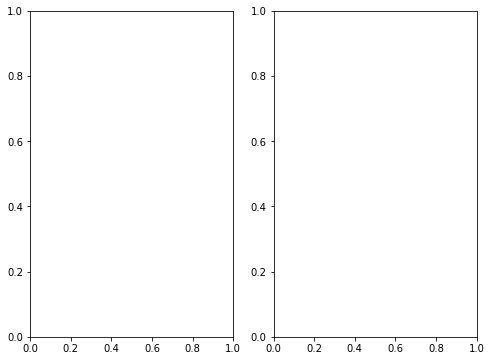

In [21]:
T_GD = 1000
eta_GD = .8
NLM_filter = .015			 		 

patch_kw = dict(patch_size=5,      # 5x5 patches
                patch_distance=6,  # 13x13 search area
                multichannel=True)

output_GD, time_per_iter_GD, psnr_per_iter_GD = PnP_GD_CSMRI(x_init, mask, y, eta_GD, T_GD, NLM_filter, patch_kw, ORIG)

# Figure to display iteration count/ clock time vs PSNR for all algorithms
psnr_fig, psnr_ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 6))

psnr_ax[0].plot(np.cumsum(time_per_iter_GD), psnr_per_iter_GD)

psnr_ax[1].plot(range(np.cumsum(time_per_iter_GD).size), psnr_per_iter_GD)

psnr_ax[0].set(xlabel='time (s)', ylabel='PSNR (dB)')
psnr_ax[0].legend(('PnP-SVRG'), loc='lower right')
psnr_ax[0].grid()

psnr_ax[1].set(xlabel='iteration', ylabel='PSNR (dB)')
psnr_ax[1].legend("PnP-SVRG", loc='lower right')
psnr_ax[1].grid()

psnr_fig.tight_layout()

plt.show()

In [ ]:
## Display output of PnP-GD
psnr_output_GD = peak_signal_noise_ratio(ORIG, output_GD)
gd_fig = plt.figure()
ax = gd_fig.add_subplot(1, 1, 1)
gd_plot = plt.imshow(output_GD, cmap='gray', vmin=0, vmax=1)
ax.set_title(f"PnP-GD, PSNR = {psnr_output_GD:0.2f}")
ax.axis('off')

$\begin{equation}
    \textbf{PnP-SGD}(\boldsymbol{x}_0, \eta, T): \\
    \text{for } t = 1, 2, . . ., T \text{ do} \\
    \hspace{2ex} \text{pick } i_t \in \{ 1, ..., m \} \text{ randomly} \\
	\hspace{2ex} \boldsymbol{x}_t = \boldsymbol{x}_{k-1} - \eta \nabla \ell_{i_t} (\boldsymbol{x}_{t-1}) \\
    \hspace{2ex} \boldsymbol{x}_t = \text{denoise}_\sigma (\boldsymbol{x}_t) \\
    \text{end} \\
    \textbf{Output } \boldsymbol{x}_T
\end{equation}$

In [ ]:
def PnP_SGD_CSMRI(z, MASK, meas, eta, T, batch_size, FILTER, patch, orig):
    ## Obtain info from inputs
    H, W = z.shape[:2] # image dimensions
    index = np.transpose(np.nonzero(MASK)) # nonzero indices of the mask
    
    ## Initialize time-keeping variables
    time_per_iter = []
    psnr_per_iter = []
    t2 = 0
    
    # Main PnP SGD routine
    for i in range(T):
        start_iter = time.time()
        # Update variables
        ind = get_batch(batch_size, H, W, index)
        v = stoch_grad(z, MASK, meas, ind)
        z = z - eta * v

        # Denoising
        ztilde = np.copy(z)
        z = denoise_nl_means(np.real(ztilde), h=FILTER, fast_mode=True, **patch)
        stop_iter = time.time()
        time_per_iter.append(stop_iter-start_iter)
        psnr_per_iter.append(peak_signal_noise_ratio(orig, z))

        print(str(i) + " " + str(peak_signal_noise_ratio(orig, z)))
        t2 += 1
    return z, time_per_iter, psnr_per_iter

In [ ]:
T_SGD = 1000
eta_SGD = .8				# step size for GD
batch_size_SGD = 1000
NLM_filter = .015			 		 

patch_kw = dict(patch_size=5,      # 5x5 patches
                patch_distance=6,  # 13x13 search area
                multichannel=True)

output_SGD, time_per_iter_SGD, psnr_per_iter_SGD = PnP_SGD_CSMRI(x_init, mask, y, eta_SGD, T_SGD, batch_size_SGD, \
                                                                 NLM_filter, patch_kw, ORIG)



In [ ]:
## Display output of PnP-SGD
psnr_output_SGD = peak_signal_noise_ratio(ORIG, output_SGD)
sgd_fig = plt.figure()
ax = sgd_fig.add_subplot(1, 1, 1)
sgd_plot = plt.imshow(output_SGD, cmap='gray', vmin=0, vmax=1)
ax.set_title(f"PnP-SGD, PSNR = {psnr_output_SGD:0.2f}")
ax.axis('off')



(Need to rewrite code. originally taken from: https://github.com/uclaopt/Provable_Plug_and_Play and not working)

$\begin{equation}
    \textbf{PnP-ADMM}(\boldsymbol{x}_0, \boldsymbol{v}_0, \boldsymbol{u}_0, \eta, T): \\
    \text{for } t = 1, 2, . . ., T \text{ do} \\
	\hspace{2ex} \boldsymbol{x}_t = \text{prox}_d (\boldsymbol{v}_{t-1} - \boldsymbol{u}_{t-1}; \eta) \\
	\hspace{2ex} \boldsymbol{v}_t = \text{denoise}_\sigma (\boldsymbol{x}_{t} + \boldsymbol{u}_{t-1}) \\
	\hspace{2ex} \boldsymbol{u}_{t} = \boldsymbol{u}_{t-1} + (\boldsymbol{x}_{t} - \boldsymbol{v}_t) \\
    \text{end}
\end{equation}$

$\text{prox}_g (\boldsymbol{z}; \eta) \overset{\Delta}{=} {\arg\min}_{\boldsymbol{x}} \left\{ g(\boldsymbol{x}) + \frac{1}{2 \eta} \| \boldsymbol{x} - \boldsymbol{z} \|_2^2 \right\}$

In [9]:
def PnP_ADMM(alpha_, T_ADMM_, NLM_filter_):
    alpha = alpha_
    T_ADMM = T_ADMM_
    NLM_filter = NLM_filter_

    x = np.copy(x_init)
    print("Initial PSNR = " + str(peak_signal_noise_ratio(ORIG, x)))
    t3 = 0

    patch_kw = dict(patch_size=5,      # 5x5 patches
                    patch_distance=6,  # 13x13 search area
                    multichannel=True)

    time_per_iter_ADMM = []
    psnr_per_iter_ADMM = []

    v = np.copy(x)
    u = np.zeros((H,W), dtype=np.float64)

    """ Main loop. """
    for i in range(T_ADMM):
        start_iter = time.time()
        xold = np.copy(x)
        vold = np.copy(v)
        uold = np.copy(u)
        """ Update variables. """

        vtilde = np.copy(x+u)
        vf = np.fft.fft2(vtilde)

        vf[index] = alpha* ((1 / 2) * vf[index] + y[index]) / (1.0 + alpha)
        v = np.real(np.fft.ifft2(vf))

        """ Denoising step. """

        xtilde = np.copy(2*v - xold - uold)
        mintmp = np.min(xtilde)
        maxtmp = np.max(xtilde)
        xtilde = (xtilde - mintmp) / (maxtmp - mintmp)
        
        print(str(i) + " " + str(peak_signal_noise_ratio(ORIG, xold)))
        
        # pytorch denoising model
        x = denoise_nl_means(np.real(xtilde), h=NLM_filter, fast_mode=True, **patch_kw)
    
        x = x * (maxtmp - mintmp) + mintmp
        
        """ Update variables. """
        u = uold + xold - v
        stop_iter = time.time()

        time_per_iter_ADMM.append(stop_iter-start_iter)
        psnr_per_iter_ADMM.append(peak_signal_noise_ratio(ORIG, x))
        print(str(i) + " " + str(peak_signal_noise_ratio(ORIG, x)))
        t3 += 1
    return x, time_per_iter_ADMM, psnr_per_iter_ADMM 

In [10]:
output_SVRG, time, psnroutput = PnP_ADMM(4, 20, 5)

## Display output of PnP-ADMM
psnr_output_ADMM = peak_signal_noise_ratio(ORIG, output_ADMM)
admm_fig = plt.figure()
ax = admm_fig.add_subplot(1, 1, 1)
admm_plot = plt.imshow(output_ADMM, cmap='gray', vmin=0, vmax=1)
ax.set_title(f"PnP-ADMM, PSNR = {psnr_output_ADMM:0.2f}")
ax.axis('off')

Initial PSNR = 12.983582530165517
0 12.983582530165517
0 9.572137131748496
1 9.572137131748496
1 10.311977809521238
2 10.311977809521238
2 10.612010413545026
3 10.612010413545026
3 10.73172735441731
4 10.73172735441731
4 10.779121303828576
5 10.779121303828576
5 10.797712512538586


KeyboardInterrupt: 

In [ ]:
psnr_list = []
num_trials = 20
alpha_list = np.linspace(3.5, 4.5, num_trials)
for i in range(num_trials):
    output_SVRG, time, psnroutput = PnP_ADMM(alpha, T_ADMM, NLM_FILTER)
    psnr_list.append(psnroutput[-1])
    
admm_fig = plt.figure()
ax = admm_fig.add_subplot(1, 1, 1)
admm_plot = plt.plot(alpha_list, psnr_list)
ax.set_title(f"alpha vs. PSNR recovery")
ax.axis('on')
plt.show()

In [ ]:
## Display output of PnP-ADMM
psnr_output_ADMM = peak_signal_noise_ratio(ORIG, output_ADMM)
admm_fig = plt.figure()
ax = admm_fig.add_subplot(1, 1, 1)
admm_plot = plt.imshow(output_ADMM, cmap='gray', vmin=0, vmax=1)
ax.set_title(f"PnP-ADMM, PSNR = {psnr_output_ADMM:0.2f}")
ax.axis('off')

$\begin{equation}
	\textbf{PnP-LSVRG}(\boldsymbol{x}_0, \eta, T, p): \\
    \text{Initialize } \boldsymbol{\tilde{x}} \\
	\text{for } t = 1, 2, . . ., T \text{ do} \\
	\hspace{2ex} \boldsymbol{w} = \underbrace{\nabla d(\tilde{\boldsymbol{x}})}_{\text{full gradient}} \\
    \hspace{2ex} \text{pick } i_t \in \{ 1, ..., n \} \text{ randomly} \\
	\hspace{2ex} \boldsymbol{v}_t = \underbrace{\nabla d_{i_t} (\boldsymbol{x}_{t-1}) - \nabla d_{i_t} (\tilde{\boldsymbol{x}}) + \boldsymbol{w}}_{\text{stochastic variance-reduced gradient}} \\
	\hspace{2ex} \boldsymbol{x}_t = \text{denoise}_\sigma (\boldsymbol{x}_{t-1} - \eta \boldsymbol{v}_t) \\
	\hspace{2ex} \text{Update} \hspace{1ex} \tilde{\boldsymbol{x}} = \boldsymbol{x}_t 
\hspace{2ex} \text{ w.p. } p \\ \text{end} \\
    \textbf{Output } \boldsymbol{x}_T
\end{equation}$

In [18]:
def PnP_LSVRG_CSMRI(z, MASK, meas, eta, T, batch_size, p, FILTER, patch, orig):
    ## Obtain info from inputs
    H, W = z.shape[:2] # image dimensions
    index = np.transpose(np.nonzero(MASK)) # nonzero indices of the mask
    
    ## Initialize time-keeping variables
    time_per_iter = []
    psnr_per_iter = []
    t4 = 0
    
    # Main PnP SVRG routine
    w = np.copy(z)
    for i in range(T):
        # outer loop
        mu = full_grad(w, MASK, meas)   	# Average gradient
        # 	w = np.copy(x) 					# reference point
        start_iter = time.time()

        # inner loop
        ind = get_batch(batch_size, MASK) 	# Get batch index(indices) in terms of (row, col)

        start_grad = time.time()
        v = stoch_grad(z, ind, meas) - stoch_grad(w, ind, meas) + mu
        z = z - eta*v

        # Denoising
        ztilde = np.copy(z)
        z = denoise_nl_means(np.real(ztilde), h=FILTER, fast_mode=True, **patch)

        # update reference point with probability 1-p
        if np.random.random() > p:
            w = np.copy(z)

        stop_iter = time.time()
        print(str(i) + " " + str(peak_signal_noise_ratio(orig, z)))
        time_per_iter.append(stop_iter - start_iter)
        psnr_per_iter.append(peak_signal_noise_ratio(orig, z))

        t4 += 1
    return z, time_per_iter, psnr_per_iter

In [19]:
T_LSVRG = 10 				# Number of outer loop iterations
eta_LSVRG = .08				# step size for SVRG
p_LSVRG = .2						# probability of NOT updating reference point
batch_size_LSVRG=30000
NLM_filter = .015
patch_kw = dict(patch_size=5,      # 5x5 patches
                patch_distance=6,  # 13x13 search area
                multichannel=True)

output_LSVRG, time_per_iter_LSVRG, psnr_per_iter_LSVRG = PnP_LSVRG_CSMRI(x_init, mask, y, eta_LSVRG, T_LSVRG, \
                                                                         batch_size_LSVRG, p_LSVRG, \
                                                                         NLM_filter, patch_kw, ORIG)

0 13.381646296443968
1 13.767222477668517
2 14.14064871804333
3 14.502263332802304
4 14.852522101179531
5 15.19250198873912
6 15.519435441981187
7 15.83537582378916
8 16.141839906099424
9 16.43076162299012


In [ ]:
## Display output of PnP-L-SVRG
psnr_output_LSVRG = peak_signal_noise_ratio(orig, output_LSVRG)
lsvrg_fig = plt.figure()
ax = lsvrg_fig.add_subplot(1, 1, 1)
lsvrg_plot = plt.imshow(output_LSVRG, cmap='gray', vmin=0, vmax=1)
ax.set_title(f"PnP-L-SVRG, PSNR = {psnr_output_LSVRG:0.2f}")
ax.axis('off')

(not yet working, need to learn how to choose parameters)

$\begin{equation}
	\textbf{PnP-LKatyusha}(\theta_1, \theta_2, p \in (0, 1], T): \\
    \text{Initialize } \boldsymbol{y}_0 = \boldsymbol{w}_0 = \boldsymbol{z}_0 \in \mathbb{R}^n, \text{ stepsize } \eta = \frac{\theta_2}{(1 + \theta_2) \theta_1} \text{ and set } \sigma = \frac{\mu}{L}\\
	\text{for } t = 1, 2, . . ., T \text{ do} \\
	\hspace{2ex} \boldsymbol{x}_t = \theta_1 \boldsymbol{z}_t + \theta_2 \boldsymbol{w}_t + (1 - \theta_1 - \theta_2) \boldsymbol{y}_k \\
    \hspace{2ex} \text{pick } i_t \in \{ 1, ..., n \} \text{ randomly} \\
	\hspace{2ex} \boldsymbol{g}_t = \nabla \ell_i (\boldsymbol{x}_t) - \nabla_i \ell_i (\boldsymbol{w}_t) + \nabla \ell (\boldsymbol{w}_t) \\
	\hspace{2ex} \boldsymbol{z}_{t+1} = \frac{1}{1 + \eta \sigma} (\eta \sigma \boldsymbol{x}_t + \boldsymbol{z}_t - \frac{\eta}{L} \boldsymbol{g}_t) \\
    \hspace{2ex} \boldsymbol{y}_{t+1} = \boldsymbol{x} + \theta_1 (\boldsymbol{z}_{t+1} - \boldsymbol{z}_t) \\
	\hspace{2ex} \text{Update} \hspace{1ex} \boldsymbol{w}_{t+1} = \boldsymbol{y}_t
\hspace{2ex} \text{ w.p. } p \\ \text{end} \\
    \textbf{Output } \boldsymbol{x}_T
\end{equation}$

In [ ]:
T_LKatyusha = 10 				# Number of outer loop iterations

p = .2						# probability of NOT updating reference point
theta1 = .1
theta2 = .1
eta_LKatyusha = theta2/((1+theta2)*theta1)				# step size for SVRG
mu = 1
L = 1
sigma = mu/L

batch_size_LKatyusha=30000
NLM_filter = .015
patch_kw = dict(patch_size=5,      # 5x5 patches
                patch_distance=6,  # 13x13 search area
                multichannel=True)

time_per_iter_LKatyusha = []
psnr_per_iter_LKatyusha = []

y = np.copy(x_init)
w = np.copy(x_init)
z = np.copy(x_init)

t5 = 0
# Main PnP SVRG routine
for i in range(T_LKatyusha):
    z_old = np.copy(z)
    x = theta1*z + theta2*w + (1 - theta1 - theta2)*y
    start_iter = time.time()

    # inner loop
    ind = get_batch(batch_size_LKatyusha, H, W, index) 	# Get batch index(indices) in terms of (row, col)

    start_grad = time.time()
    g = stoch_grad(x, mask, y, ind) - stoch_grad(w, mask, y, ind) + full_grad(w, mask, y)
    z = (1 / (1 + eta_LKatyusha*sigma))*(eta_LKatyusha*sigma*x + z - eta_LKatyusha / L * g)
    y = x + theta1*(z - z_old)
    
    # Denoising
    wtilde = np.copy(w)

    # denoise
    w = denoise_nl_means(np.real(wtilde), h=NLM_filter, fast_mode=True, **patch_kw)
    print(str(i) + " " + str(peak_signal_noise_ratio(orig, w)))

    # update reference point with probability 1-p
    if np.random.random() > p:
        w = np.copy(y)
        
    stop_iter = time.time()
    time_per_iter_LKatyusha.append(stop_iter - start_iter)
    psnr_per_iter_LKatyusha.append(peak_signal_noise_ratio(orig, w))

    t5 += 1
output_LKatyusha = w

In [ ]:
## Display output of PnP-L-Katyusha
psnr_output_LKatyusha = peak_signal_noise_ratio(orig, output_LKatyusha)
lkatyusha_fig = plt.figure()
ax = lkatyusha_fig.add_subplot(1, 1, 1)
lkatyusha_plot = plt.imshow(output_LKatyusha, cmap='gray', vmin=0, vmax=1)
ax.set_title(f"PnP-L-Katyusha, PSNR = {psnr_output_LKatyusha:0.2f}")
ax.axis('off')

In [ ]:
# Figure to display iteration count/ clock time vs PSNR for all algorithms
psnr_fig, psnr_ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 6))

psnr_ax[0].plot(np.cumsum(time_per_iter_SVRG), psnr_per_iter_SVRG)
psnr_ax[0].plot(np.cumsum(time_per_iter_GD), psnr_per_iter_GD)
psnr_ax[0].plot(np.cumsum(time_per_iter_SGD), psnr_per_iter_SGD)
psnr_ax[0].plot(np.cumsum(time_per_iter_ADMM), psnr_per_iter_ADMM)
psnr_ax[0].plot(np.cumsum(time_per_iter_LSVRG), psnr_per_iter_LSVRG)
psnr_ax[0].plot(np.cumsum(time_per_iter_LKatyusha), psnr_per_iter_LKatyusha)

psnr_ax[1].plot(range(t0), psnr_per_iter_SVRG)
psnr_ax[1].plot(range(t1), psnr_per_iter_GD)
psnr_ax[1].plot(range(t2), psnr_per_iter_SGD)
psnr_ax[1].plot(range(t3), psnr_per_iter_ADMM)
psnr_ax[1].plot(range(t4), psnr_per_iter_LSVRG)
psnr_ax[1].plot(range(t5), psnr_per_iter_LKatyusha)

psnr_ax[0].set(xlabel='time (s)', ylabel='PSNR (dB)')
# psnr_ax[0].legend(('PnP-SVRG', 'PnP-GD', 'PnP-SGD', 'PnP-ADMM', 'PnP-LSVRG', 'PnP-LKatyusha'), loc='lower right')
psnr_ax[0].legend(('PnP-SVRG', 'PnP-GD'), loc='lower right')
psnr_ax[0].grid()

psnr_ax[1].set(xlabel='iteration', ylabel='PSNR (dB)')
# psnr_ax[1].legend(('PnP-SVRG','PnP-GD', 'PnP-SGD', 'PnP-ADMM', 'PnP-LSVRG', 'PnP-LKatyusha'), loc='lower right')
psnr_ax[1].legend(('PnP-SVRG','PnP-GD'), loc='lower right')
psnr_ax[1].grid()

psnr_fig.tight_layout()

plt.show()